In [1]:
import copy
import os
import scipy.io as sio
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import scipy

from yass.evaluate.stability import *
from yass.evaluate.util import *
from yass.geometry import parse, find_channel_neighbors
from yass.deconvolute.ind_run import run

from deconv_exp_utils import *
from match_pursuit import MatchPursuit

from tqdm import tqdm
#import mpld3

from deconv_exp_utils import vis_chan, recon

%matplotlib inline

/home/hooshmand/Documents/github/yassenv/local/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Load Data and Gold Standard Spike Traing

In [2]:
base_dir = '/ssd/data/peter/ej49_dataset'

raw = os.path.join(base_dir, 'ej49_data1_set1.bin')
geom = os.path.join(base_dir, 'ej49_geometry1.txt')
st_file = os.path.join(base_dir, 'groundtruth_ej49_data1_set1.mat')

rbi = RecordingBatchIterator(
    rec_file=raw, n_chan=49, batch_time_samples=2000000,
    geom_file=geom, n_batches=3, radius=70, sample_rate=20000,
    whiten=False)

# Real Or Synthetic Dataset

By setting `REAL` to `True` the algorithm will run on real dataset. Otherwise, we synthesize data.

In [3]:
REAL = True
# Lenght of recording in time samples.
TOT_TIME = int(20000 * 10)
T = TOT_TIME

if REAL:
    rbi.reset_cursor()
    data = rbi.next_batch()
    data = data[:T, :]
    print data.shape

(200000, 49)


# Compute Mean Wave Form

Set `LOAD` variable to `True` if the waveforms have been computed and the results are saved locally.

In [4]:
# Set to False if it is the first time runing
LOAD = True

temp_file = 'gold_temp.npy'
align_temp_file = 'align_gold_temp.npy'
gold_sp_file = 'gold_sp.npy'

if not LOAD:
    gold_sp = sio.loadmat(st_file)
    gold_sp = np.append(gold_sp['spt_gt'], gold_sp['L_gt'])
    gold_sp = gold_sp.reshape([2, len(gold_sp) // 2]).T

    mwc = MeanWaveCalculator(batch_reader=rbi, spike_train=gold_sp, window=range(-20, 30))
    mwc.compute_templates(6)
    mwc_temps = mwc.templates
    np.save(temp_file, mwc_temps)
    np.save(gold_sp_file, gold_sp)

    # align templates or not
    align_temps = []
    n_unit = mwc_temps.shape[2]
    for unit in tqdm(range(n_unit)):
        t, _ = optimal_aligned_compress(mwc_temps[:, :, unit])
        align_temps.append(t.T)
    align_temps = np.array(align_temps).T
    align_temps = scipy.signal.resample(align_temps, int(align_temps.shape[0] / 5.))
    np.save(align_temp_file, align_temps)

else:
    gold_sp = np.load(gold_sp_file)
    mwc_temps = np.load(temp_file)
    align_temps = np.load(align_temp_file)

# Use Subset of Cells Only

If you would like to use only a subset of the gold standard units
to create synthetic data set variables `SUBSET` and `only_units` accordintly.

In [5]:
SUBSET = True

# Units with SNR more than 4
only_units = np.where(compute_snr(mwc_temps) > 4)[0]

if SUBSET:
    spt_idx = gold_sp[:, 1] == only_units[0]
    for i in range(1, len(only_units)):
        spt_idx = np.logical_or(spt_idx, gold_sp[:, 1] == only_units[i])
    gold_sp = gold_sp[spt_idx, :]

    cid = 0
    for unit in only_units:
        gold_sp[gold_sp[:, 1] == unit, 1] = cid
        cid += 1
    mwc_temps = mwc_temps[:, :, only_units]

In [6]:
VIS = False
if VIS:
    fig, ax = plt.subplots(7, 7)
    for i in range(49):
        ax[i // 7, i % 7].plot(mwc_temps[:, :, i])
    fig.set_size_inches(40, 40)

In [19]:
gold_sp

array([[      7,      33],
       [     13,      21],
       [     51,      23],
       ...,
       [5999929,      37],
       [5999931,      27],
       [5999991,       6]], dtype=int32)

# Set Parameters for Synthetic Data (Skip if Real Data Used)

In [6]:
# Rank of SVD decomposition of approximating
# Convolution operation.
RANK = 3
# Whether to use aligned version of templates.
ALIGN = False
# Whether to add noise to the data set or not.
NOISE = False


gold_sp = enforce_refractory_period(gold_sp, refractory_period=40)
data = fake_data(spt=gold_sp, temps=mwc_temps, length=T, noise=NOISE)

# Visualize the First Temporal Chunk of the Recording

Text(0.5,1,u'Temporal chunk of recording')

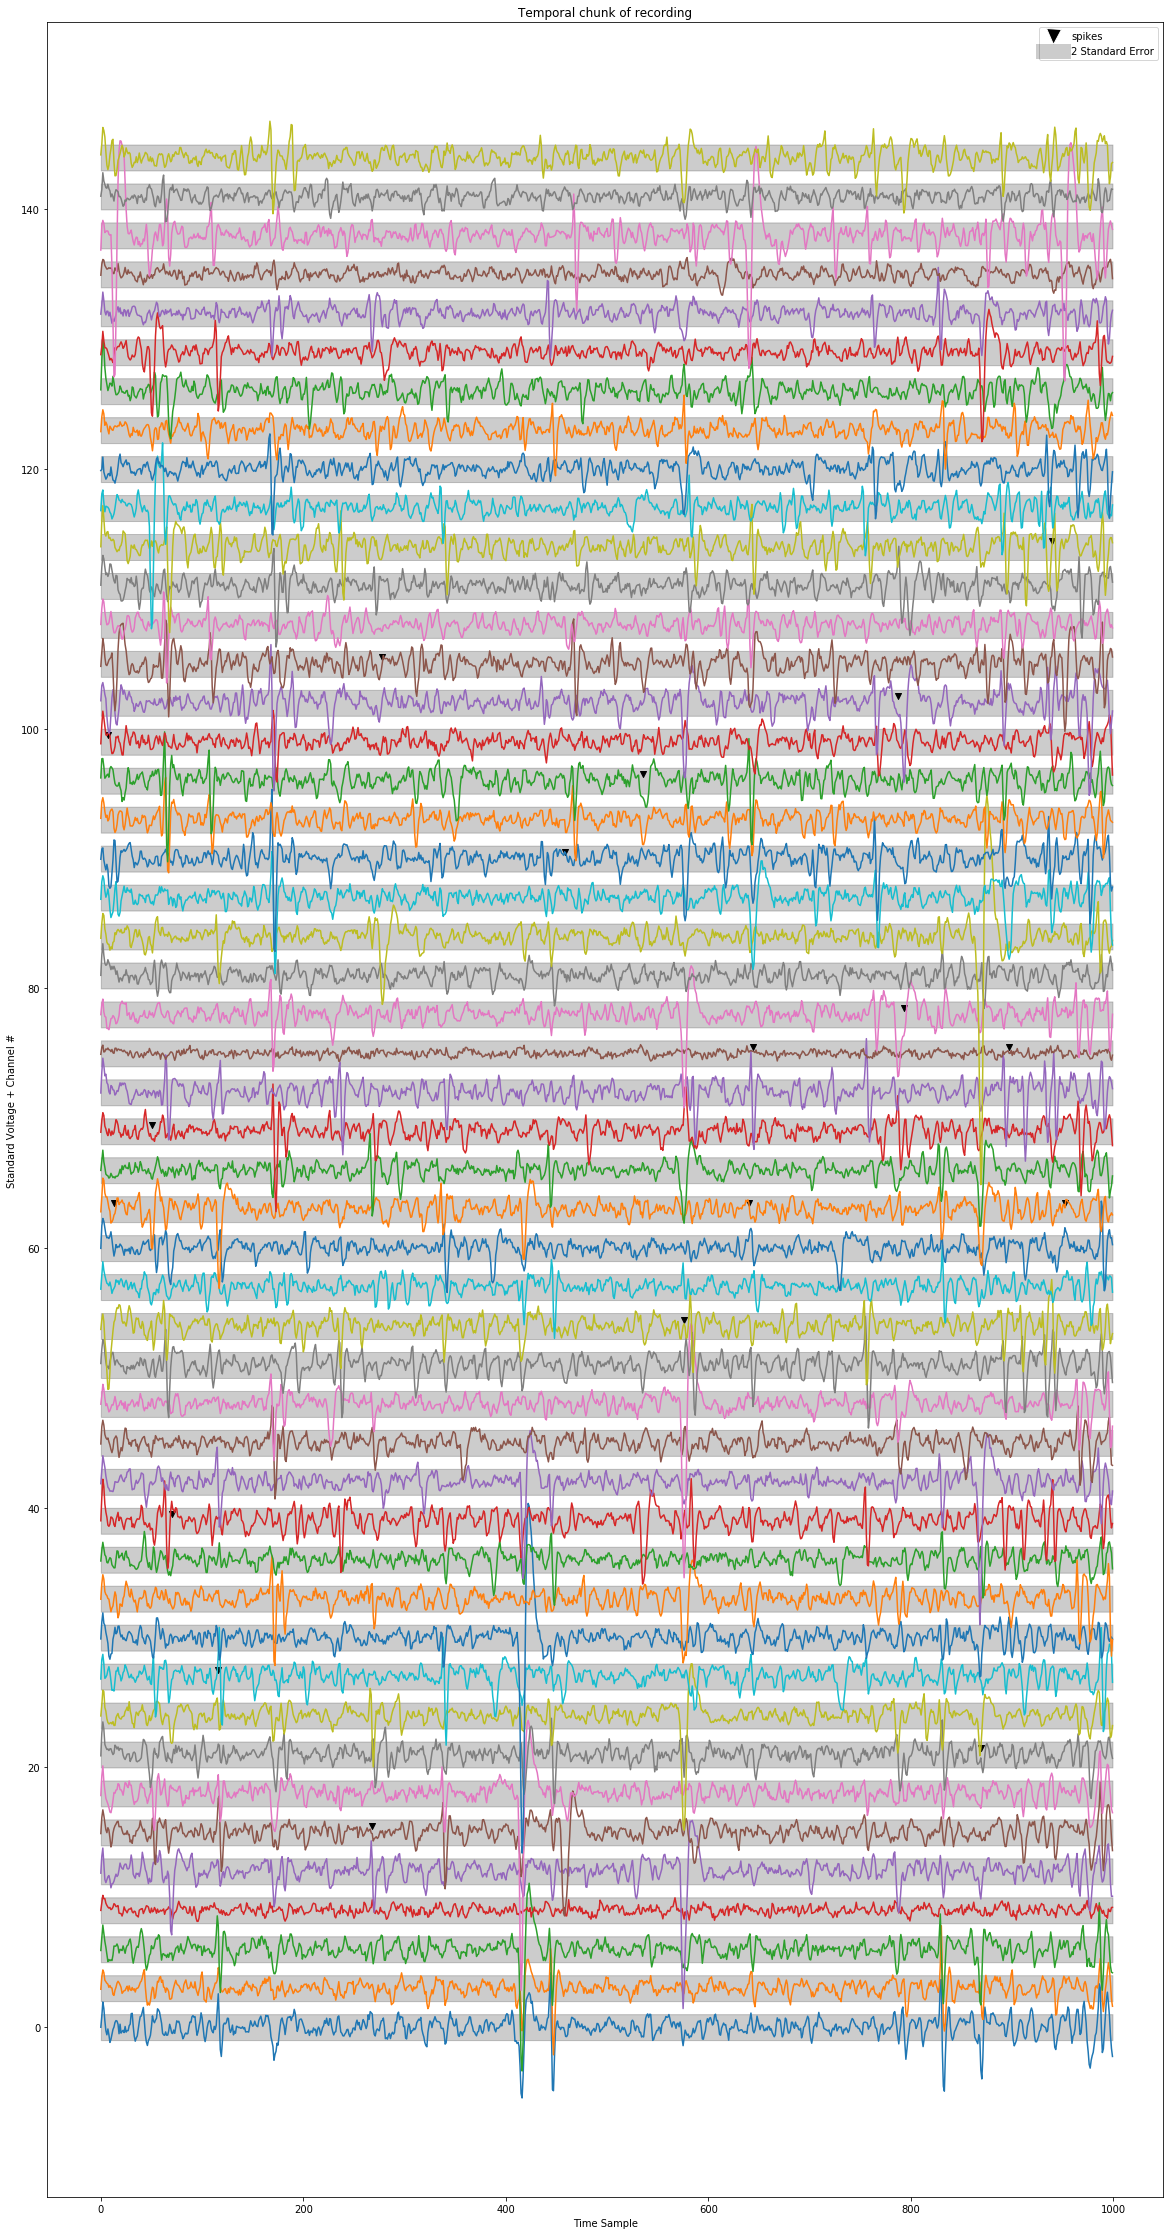

In [6]:
trunc_to = 1000
gold_sp_trunc = gold_sp[gold_sp[:, 0] < trunc_to, :]

fig, ax = plt.subplots()
for c in range(49):
    unit_sp = gold_sp_trunc[gold_sp_trunc[:, 1] == c, 0]
    offset = 3 * c
    ax.scatter(unit_sp, np.zeros(len(unit_sp)) + offset + 0.5, color='0', marker='v')
    ax.plot(data[:trunc_to, c] + offset)
    ax.fill_between(
        range(trunc_to),
        np.zeros(trunc_to) + offset + 1,
        np.zeros(trunc_to) + offset - 1, color='0', alpha=0.2)

legend_elements = [Line2D([0], [0], marker='v', color='w', label='spikes',
                          markerfacecolor='0', markersize=15),
                   Line2D([0], [0], lw=15, color='0', alpha=0.2, label='2 Standard Error')]
ax.legend(handles=legend_elements)

fig.set_size_inches(20, 40)
ax.set_xlabel("Time Sample")
ax.set_ylabel("Standard Voltage + Channel #")
ax.set_title("Temporal chunk of recording")

In [7]:
data1 = copy.copy(data)
mp = MatchPursuit(data1, mwc_temps, threshold=2, obj_energy=False)

# Let's visualize a Temporal Chunk of the Objective Matrix

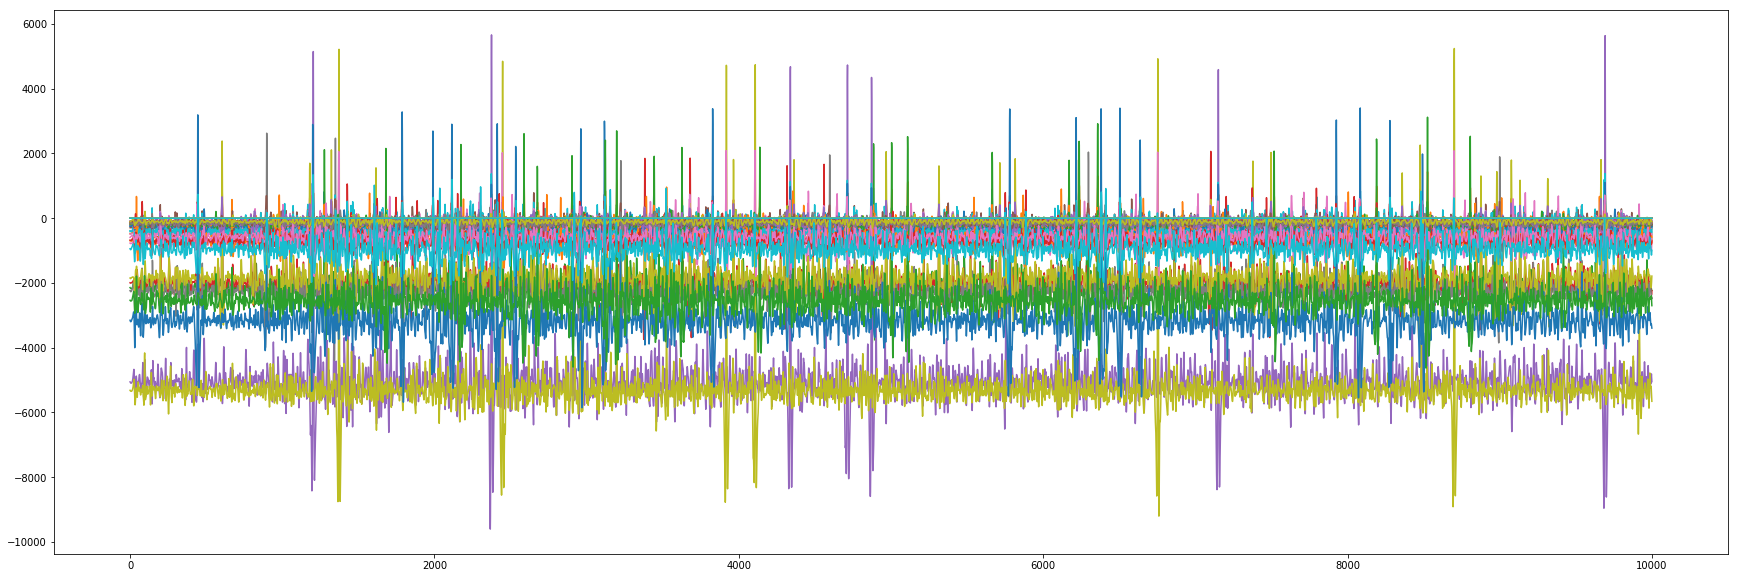

In [8]:
o1 = mp.compute_objective()

fig, ax = plt.subplots()
vis_o = o1[:, 0:10000]
ax.plot(vis_o.T)
ax.plot(vis_o.T * 0)
fig.set_size_inches(30, 10)
plt.show()

# Let's Run Deconvolution for a Fixed # of Iterations

In [9]:
deconvd_sp, dist_metric = mp.run(max_iter=20)
deconvd_sp[:, 0] += 25

Iteration 1 Found 1932 spikes with Max Obj 6003.41108296.
Iteration 2 Found 1801 spikes with Max Obj 5214.38283739.
Iteration 3 Found 1730 spikes with Max Obj 2754.29521919.
Iteration 4 Found 1707 spikes with Max Obj 1983.17167191.
Iteration 5 Found 1632 spikes with Max Obj 1983.17167191.
Iteration 6 Found 1552 spikes with Max Obj 1983.9027968.
Iteration 7 Found 1469 spikes with Max Obj 1983.9027968.
Iteration 8 Found 1350 spikes with Max Obj 1983.9027968.
Iteration 9 Found 1167 spikes with Max Obj 1983.9027968.
Iteration 10 Found 964 spikes with Max Obj 1983.9027968.
Iteration 11 Found 793 spikes with Max Obj 1983.9027968.
Iteration 12 Found 617 spikes with Max Obj 1983.9027968.
Iteration 13 Found 458 spikes with Max Obj 1983.9027968.
Iteration 14 Found 327 spikes with Max Obj 1983.9027968.
Iteration 15 Found 206 spikes with Max Obj 1983.9027968.
Iteration 16 Found 140 spikes with Max Obj 1983.9027968.
Iteration 17 Found 94 spikes with Max Obj 1983.9027968.
Iteration 18 Found 63 spike

In [10]:
gold_sp_trunc = gold_sp[gold_sp[:, 0] < TOT_TIME, :]
print "Ground Truth Spikes #:\t\t{}".format(gold_sp[gold_sp[:, 0] < 20000 * 10, :].shape[0])
print "Recovered Truth Spikes #:\t{}".format(deconvd_sp.shape[0])

Ground Truth Spikes #:		5880
Recovered Truth Spikes #:	18061


# Let's visualize a Temporal Cunk of the Objective Matrix Ater Deconv

/home/hooshmand/Documents/github/yassenv/lib/python2.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in multiply
  


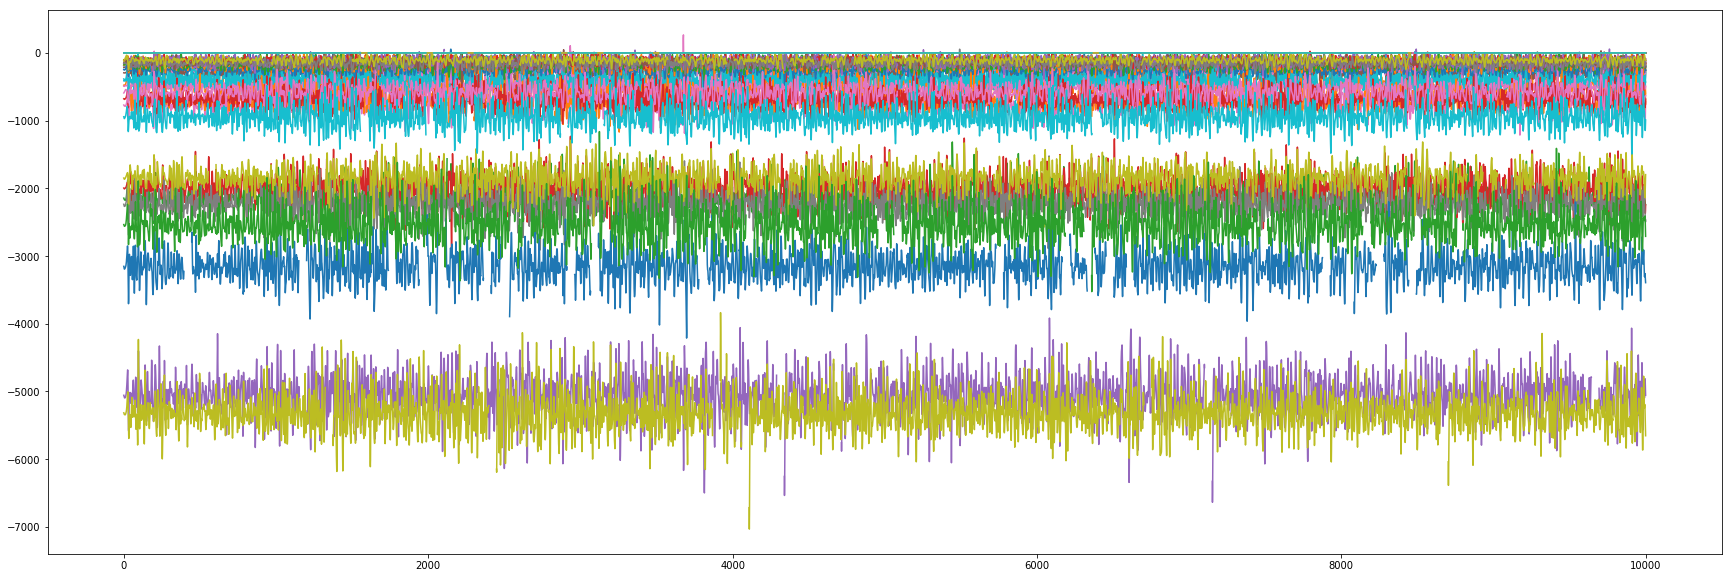

In [10]:
o1 = mp.compute_objective()

fig, ax = plt.subplots()
vis_o = o1[:, 0:10000]
ax.plot(vis_o.T)
ax.plot(vis_o.T * 0)
fig.set_size_inches(30, 10)
plt.show()

In [17]:
# Geometry of the probe (N x 2)
geom_m = parse(os.path.join(base_dir, geom), 49)
# Main channels per unit
m_c = main_channels(mwc_temps)[:, -1]
temps = mwc_temps
# SNR's per unit in terms of peak to peak ratio
snrs = compute_snr(temps)

# Summary of Performance

In [18]:
print 'unit\t#sp\t%TP\t%FP\tSNR\tmain ch'

TOT_UNITS = np.unique(gold_sp_trunc[:, 1])
gold_sp_trunc = gold_sp[gold_sp[:, 0] < TOT_TIME, :]
diffs = []
#for unit in :
tps = []
fps = []
match_idx = []
miss_idx = []
unit_sp_count = []


# Compute true positives and false negatives
for unit in TOT_UNITS:
    gsp = gold_sp_trunc[gold_sp_trunc[:, 1] == unit, 0]
    sp = np.sort(deconvd_sp[deconvd_sp[:, 1] == unit, 0])
    n_spikes = len(gsp)
    n_recovered = len(sp)
    unit_match_idx, unit_miss_idx = count_matches(gsp, sp)
    match_idx.append(unit_match_idx)
    miss_idx.append(unit_miss_idx)
    n_matches = len(unit_match_idx)
    n_misses = len(unit_miss_idx)
    #
    tp = (n_matches * 1.) / n_spikes
    fp = (n_misses * 1.) / n_recovered
    diffs.append(n_spikes - n_recovered)
    tps.append(tp)
    fps.append(fp)
    unit_sp_count.append(n_spikes)


for unit in np.argsort(snrs):
    print '{0}\t{1}\t{2:.2f}\t{3:.2f}\t{4:.1f}\t{5}'.format(
        unit, unit_sp_count[unit], tps[unit], fps[unit], snrs[unit], m_c[unit])


unit	#sp	%TP	%FP	SNR	main ch
24	309	0.94	0.89	4.0	44
28	15	0.80	0.80	4.5	42
10	52	0.96	0.89	4.9	33
38	44	0.89	0.85	4.9	42
37	175	0.99	0.31	5.2	43
12	100	0.98	0.84	5.3	15
29	101	0.96	0.66	5.4	9
34	133	0.93	0.87	5.7	26
33	167	0.99	0.69	5.7	18
35	233	0.99	0.17	5.8	28
11	67	1.00	0.87	5.9	37
31	106	0.97	0.78	6.1	24
5	72	0.97	0.92	6.1	22
13	93	0.98	0.70	6.2	4
14	38	0.97	0.70	6.7	42
32	152	1.00	0.72	6.8	13
25	211	1.00	0.62	6.8	29
0	58	1.00	0.12	6.9	45
26	140	1.00	0.75	6.9	34
19	313	0.94	0.32	7.0	19
27	125	0.99	0.53	7.3	12
9	86	0.95	0.90	7.4	9
1	71	0.97	0.57	7.5	31
36	162	0.96	0.10	7.9	0
17	125	0.98	0.45	8.2	21
30	294	0.99	0.10	8.4	5
15	45	0.87	0.33	8.5	10
39	47	0.94	0.15	9.7	10
23	394	0.97	0.01	13.4	39
16	51	1.00	0.06	15.7	47
18	322	1.00	0.01	16.9	16
6	132	0.98	0.00	17.8	48
21	333	1.00	0.03	17.9	46
3	65	1.00	0.00	20.1	11
2	121	1.00	0.00	25.2	37
20	242	0.95	0.37	25.7	10
7	101	0.99	0.00	28.2	28
22	412	0.98	0.00	28.9	31
4	68	1.00	0.03	41.5	9
8	105	1.00	0.00	46.9	47


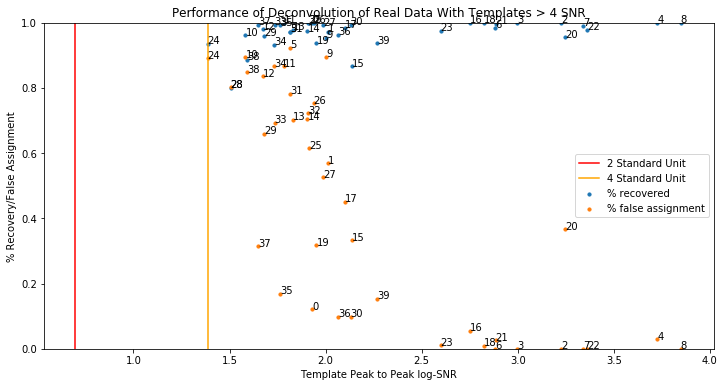

In [19]:
log_snrs = np.log(snrs)

plt.scatter(log_snrs, tps, s=10)
plt.scatter(log_snrs, fps, s=10)
for u in TOT_UNITS:
    plt.gca().annotate(u, (log_snrs[u], tps[u]))
    plt.gca().annotate(u, (log_snrs[u], fps[u]))
plt.axvline(np.log(2), color='r')
plt.axvline(np.log(4), color='orange')
plt.legend(['2 Standard Unit', '4 Standard Unit', '% recovered', '% false assignment'])
plt.xlabel('Template Peak to Peak log-SNR')
plt.ylabel('% Recovery/False Assignment')
plt.title('Performance of Deconvolution of Real Data With Templates > 4 SNR')
plt.gcf().set_size_inches(12, 6)
#plt.xlim(0, 4)
plt.ylim(0, 1)
#plt.savefig('Deconv_Performance_Real_Data_Strong_Templates.pdf')

In [20]:
all_units = np.unique(gold_sp_trunc[:, 1])
# Units that have a large difference in recovered vs. original
bad_units = np.where(np.abs(diffs) > 5)[0]

In [21]:
def mean_wave_form(data, spike_times, window=np.arange(-25, 25, 1), mode='mean'):
    sp = spike_times[:, np.newaxis] + np.arange(-25, 25, 1)
    if mode == 'mean':
        return np.mean(data[:, :][sp], axis=0)
    else:
        return np.median(data[:, :][sp], axis=0)

def all_wave_form(data, spike_times, window=np.arange(-25, 25, 1)):
    sp = spike_times[:, np.newaxis] + np.arange(-25, 25, 1)
    return data[:, :][sp]

# Visualize Spatial Traces of Templates and Recovered Mean Wave Forms

100%|██████████| 2/2 [00:00<00:00,  3.58it/s]


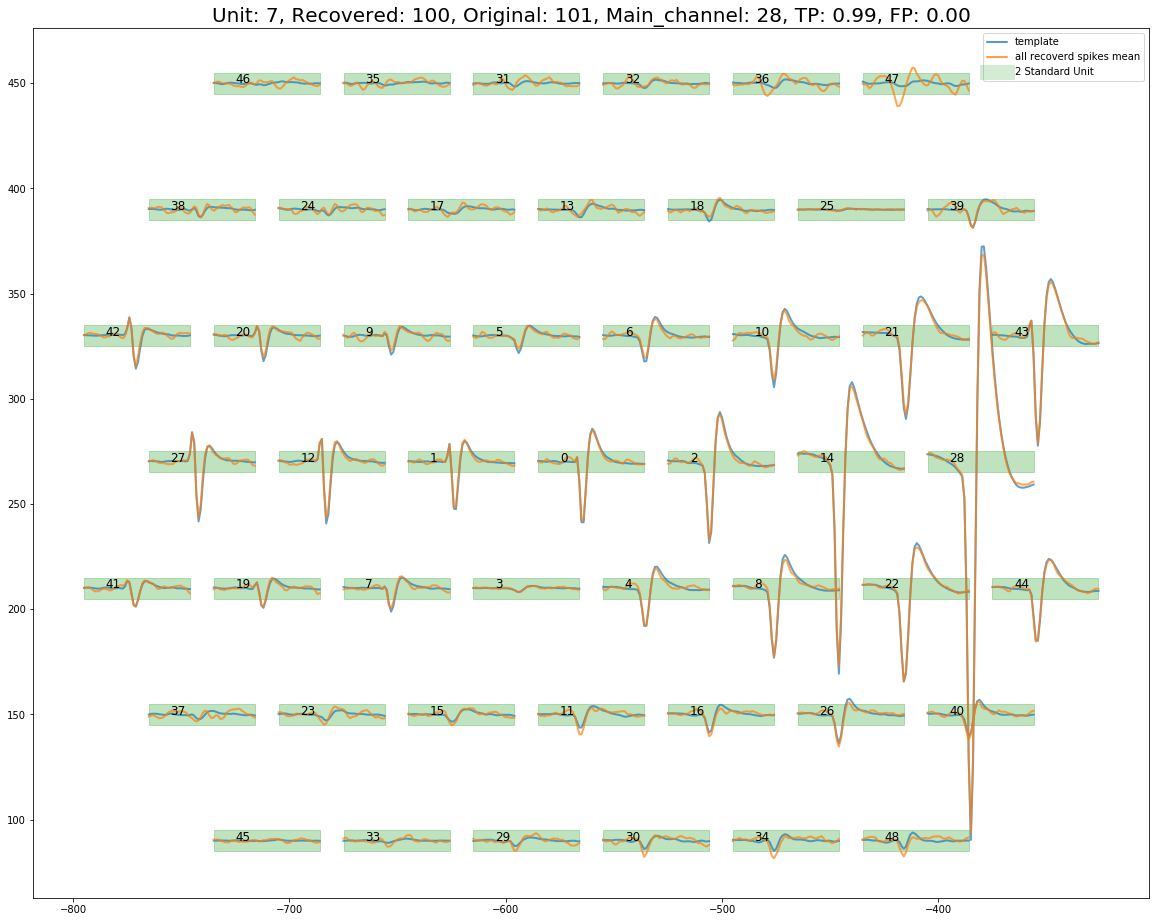

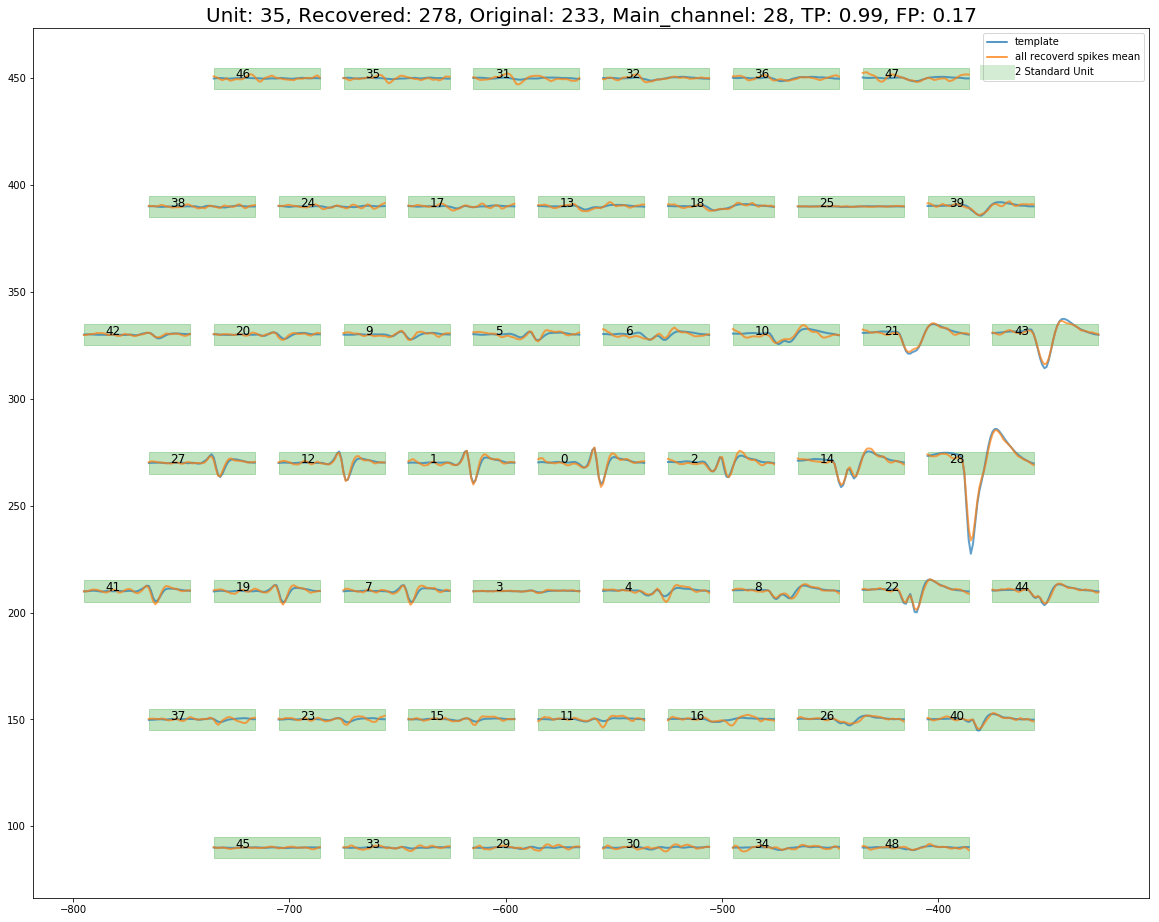

In [67]:
# For plotting purposes
squeeze = 1.
# Which units to visualize
main_channel = 28
show_units = np.where(m_c == main_channel)[0]


gold_sp_trunc = gold_sp[gold_sp[:, 0] < TOT_TIME, :]
for unit in tqdm(show_units):
    fig, ax = plt.subplots()
    sp = deconvd_sp[deconvd_sp[:, 1] == unit, 0]
    mean_rec = mean_wave_form(data, sp)
    plot_spatial(geom_m, temps[:, :, unit], ax, color='C0', scale=10., squeeze=squeeze)
    plot_spatial(geom_m, mean_rec, ax, color='C1', scale=10., squeeze=squeeze)
    plot_spatial_fill(geom_m, temps[:, :, unit] * 0, ax, color='C2', scale=10., squeeze=squeeze)
    plot_chan_numbers(geom_m, ax)
    # Add legends.
    legend_elements = [Line2D([0], [0], color='C0', label='template'),
                       Line2D([0], [0], color='C1', label='all recoverd spikes mean'),
                       Line2D([0], [0], lw=15, color='C2', alpha=0.2, label='2 Standard Unit')]
    ax.legend(handles=legend_elements)
    ax.set_title('Unit: {0}, Recovered: {1}, Original: {2}, Main_channel: {3}, TP: {4:.2f}, FP: {5:.2f}'.format(
        unit, len(sp), np.sum(gold_sp_trunc[:, 1] == unit), m_c[unit], tps[unit], fps[unit]), fontsize=20)
    fig.set_size_inches(20, 16)
    #plt.savefig('deconv_templates_easy_unit{}.pdf'.format(unit))

# Visualize Individual Units In More Detail

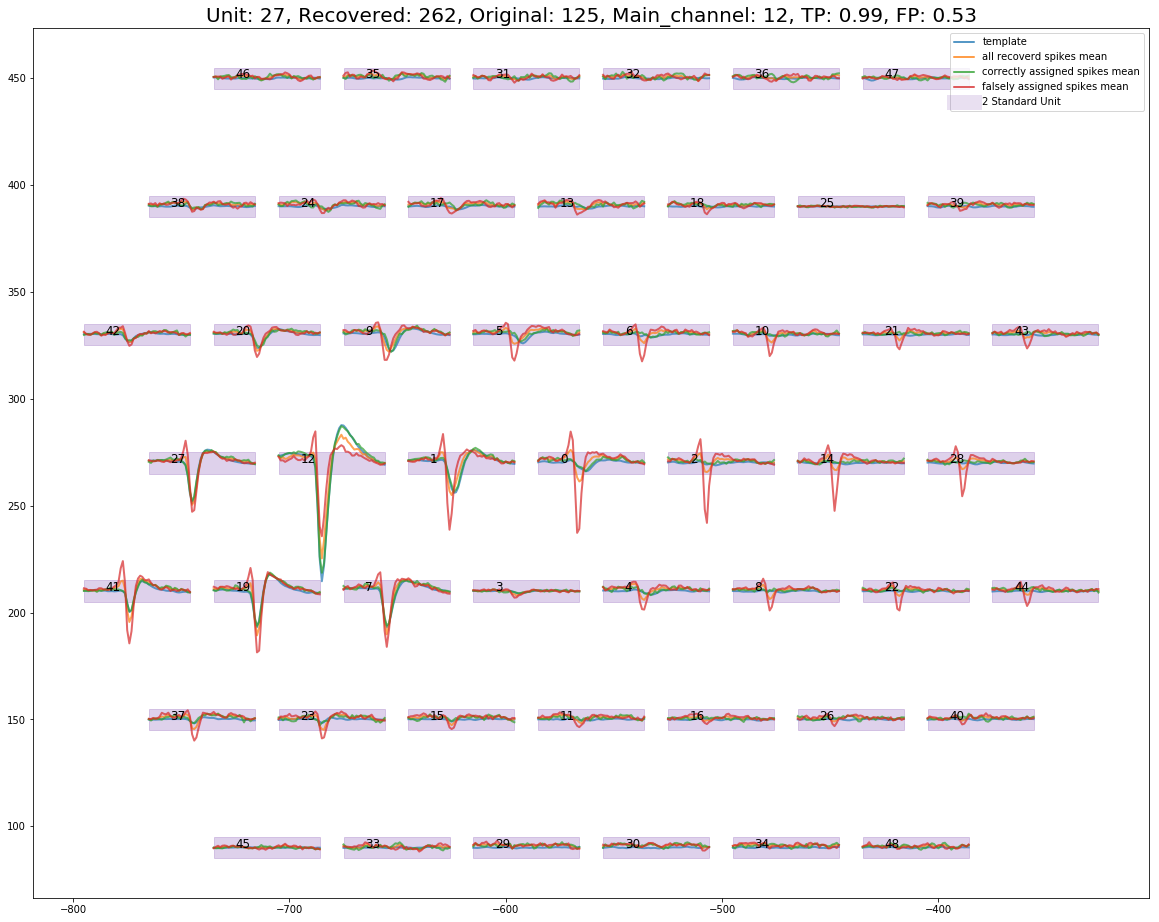

In [68]:
unit = 27
# For plotting purposes
squeeze = 1.
# Summary types for spikes
mode = 'median'

fig, ax = plt.subplots()
# Mean wave form of recovered spikes
rec_sp = np.sort(deconvd_sp[deconvd_sp[:, 1] == unit, 0])
mean_rec = mean_wave_form(data, rec_sp, mode=mode)
# Mean wave form of matched spikes
mean_true = mean_wave_form(data, rec_sp[match_idx[unit]], mode=mode)
# Mean wave form of false positives
mean_false = mean_wave_form(data, rec_sp[miss_idx[unit]], mode=mode)

plot_spatial(geom_m, temps[:, :, unit], ax, color='C0', scale=10., squeeze=squeeze)
plot_spatial(geom_m, mean_rec, ax, color='C1', scale=10., squeeze=squeeze)
plot_spatial(geom_m, mean_true, ax, color='C2', scale=10., squeeze=squeeze)
plot_spatial(geom_m, mean_false, ax, color='C3', scale=10., squeeze=squeeze)
plot_spatial_fill(geom_m, temps[:, :, unit] * 0, ax, color='C4', scale=10., squeeze=squeeze)
plot_chan_numbers(geom_m, ax)
# Add legends.
legend_elements = [Line2D([0], [0], color='C0', label='template'),
                   Line2D([0], [0], color='C1', label='all recoverd spikes mean'),
                   Line2D([0], [0], color='C2', label='correctly assigned spikes mean'),
                   Line2D([0], [0], color='C3', label='falsely assigned spikes mean'),
                   Line2D([0], [0], lw=15, color='C4', alpha=0.2, label='2 Standard Unit')]
ax.legend(handles=legend_elements)
ax.set_title('Unit: {0}, Recovered: {1}, Original: {2}, Main_channel: {3}, TP: {4:.2f}, FP: {5:.2f}'.format(
    unit, len(rec_sp), np.sum(gold_sp_trunc[:, 1] == unit), m_c[unit], tps[unit], fps[unit]), fontsize=20)
fig.set_size_inches(20, 16)

# Go Into Further Detail (Individual Spikes)

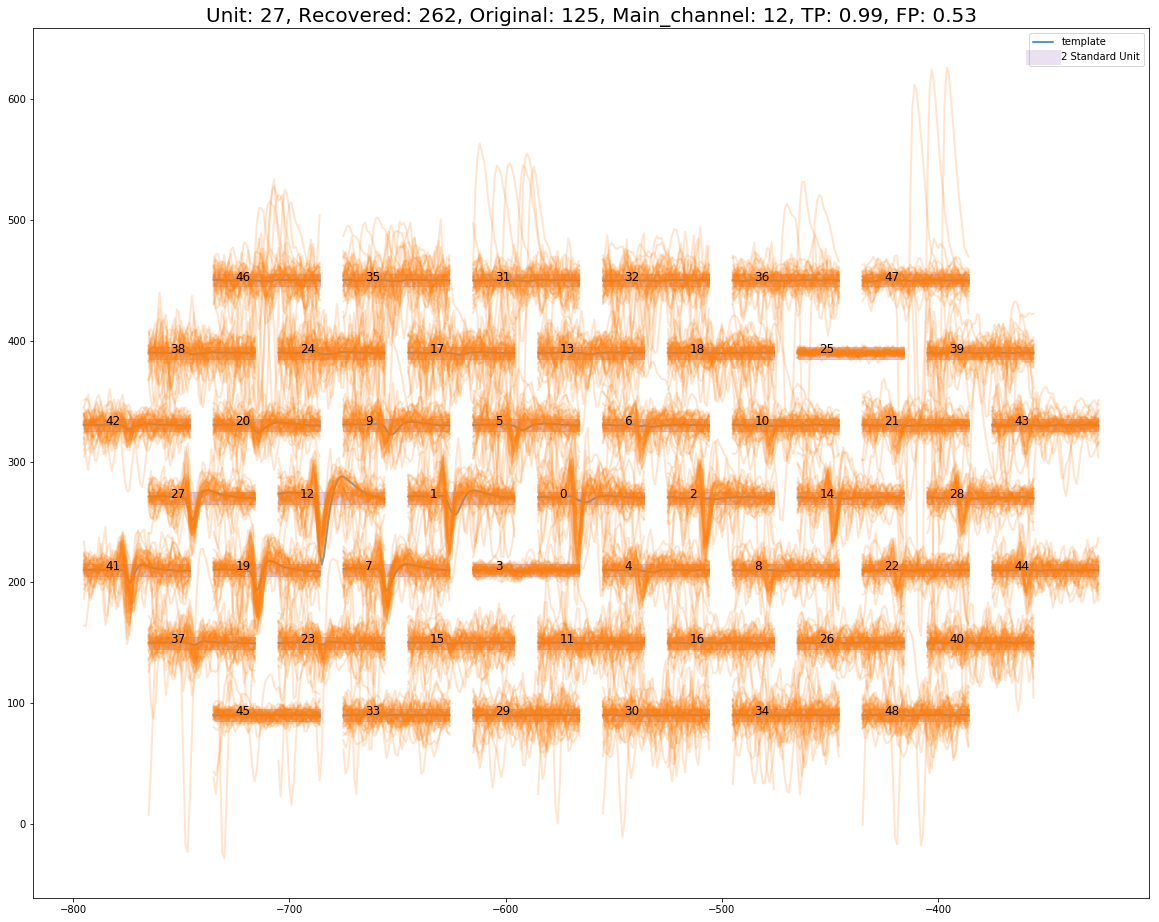

In [70]:
unit = 27
# For plotting purposes
squeeze = 1.
max_spikes = 40

fig, ax = plt.subplots()
# Mean wave form of recovered spikes
rec_sp = np.sort(deconvd_sp[deconvd_sp[:, 1] == unit, 0])
# Falsely assigned spikes
all_false = all_wave_form(data, rec_sp[miss_idx[unit]])

plot_spatial(geom_m, temps[:, :, unit], ax, color='C0', scale=10., squeeze=squeeze)

# Randomly select spikes to visualize if there are two many
vis_spikes = range(len(miss_idx[unit]))
if len(vis_spikes) > max_spikes:
    vis_spikes = np.random.choice(len(miss_idx[unit]), max_spikes, replace=False)
for i in vis_spikes:
    plot_spatial(geom_m, all_false[i, :, :], ax, color='C1', alpha=0.2, scale=10., squeeze=squeeze)
plot_spatial_fill(geom_m, temps[:, :, unit] * 0, ax, color='C4', scale=10., squeeze=squeeze)
plot_chan_numbers(geom_m, ax)
# Add legends.
legend_elements = [Line2D([0], [0], color='C0', label='template'),
                   Line2D([0], [0], lw=15, color='C4', alpha=0.2, label='2 Standard Unit')]
ax.legend(handles=legend_elements)
ax.set_title('Unit: {0}, Recovered: {1}, Original: {2}, Main_channel: {3}, TP: {4:.2f}, FP: {5:.2f}'.format(
    unit, len(rec_sp), np.sum(gold_sp_trunc[:, 1] == unit), m_c[unit], tps[unit], fps[unit]), fontsize=20)
fig.set_size_inches(20, 16)

# Let's look at distribution of distant metrics for templates

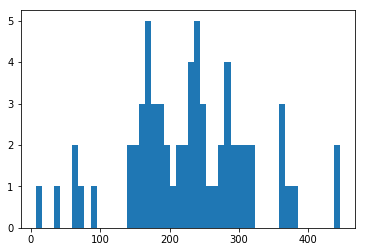

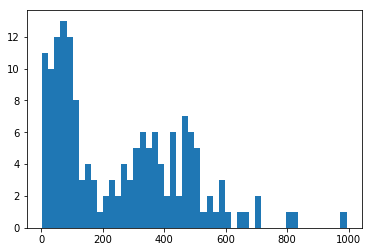

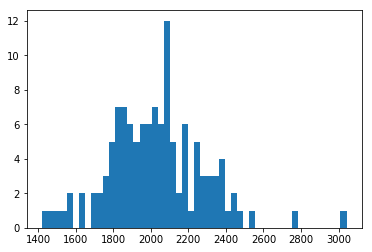

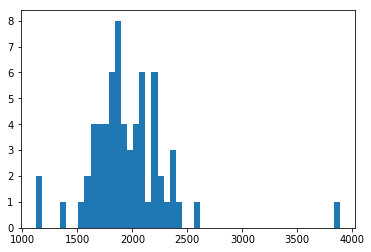

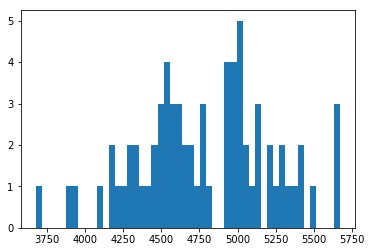

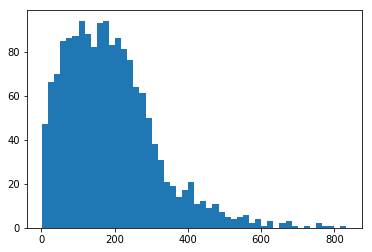

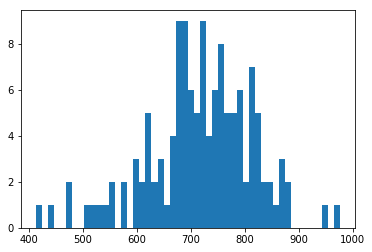

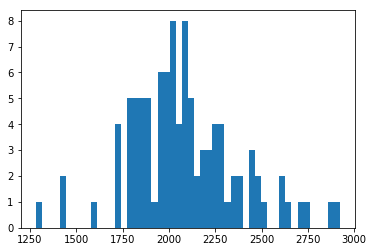

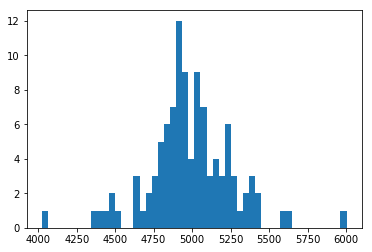

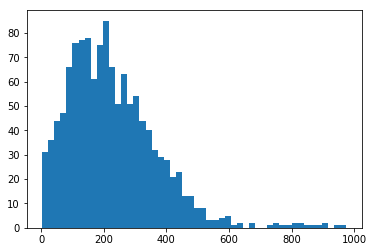

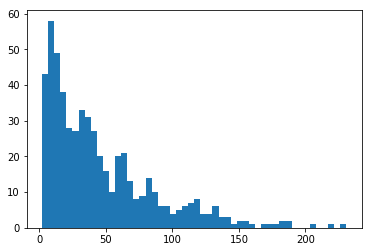

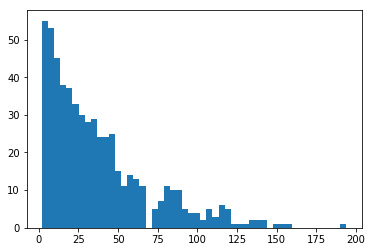

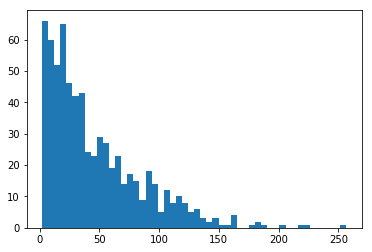

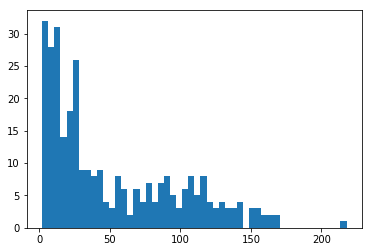

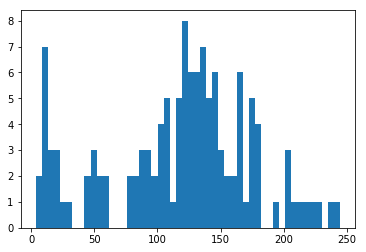

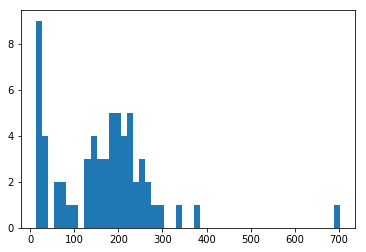

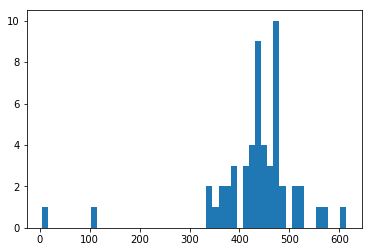

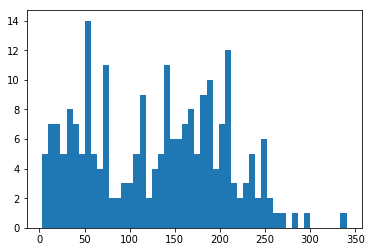

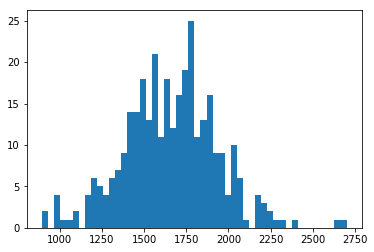

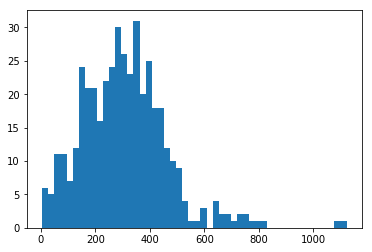

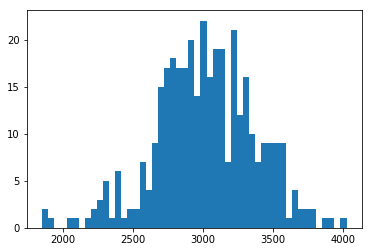

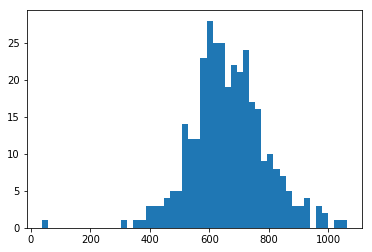

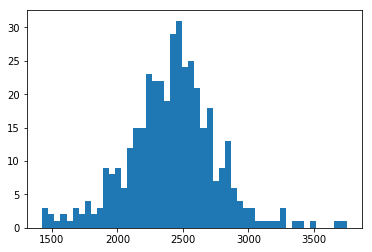

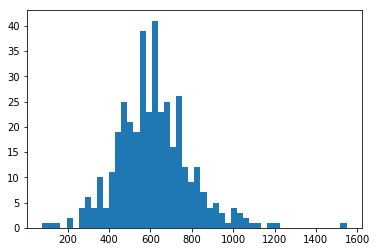

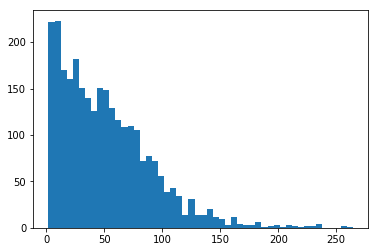

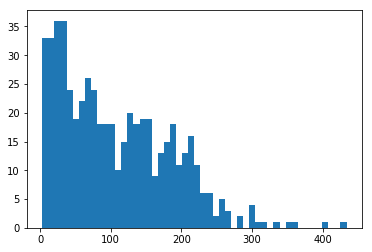

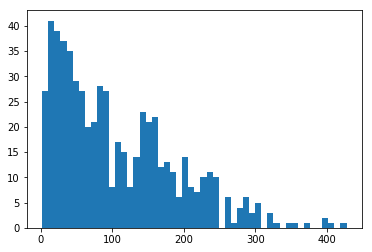

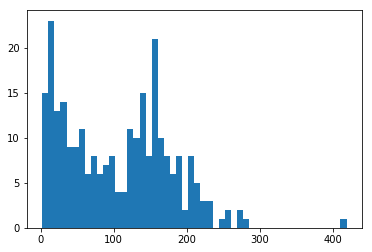

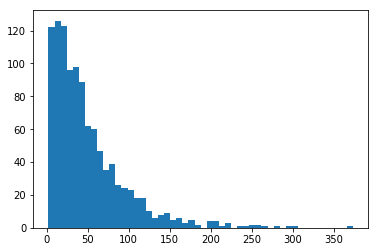

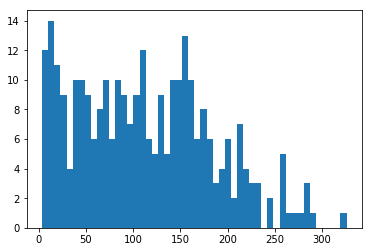

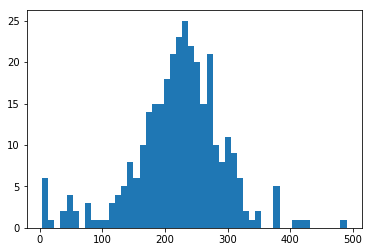

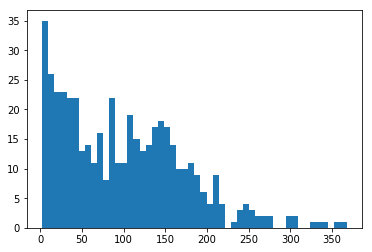

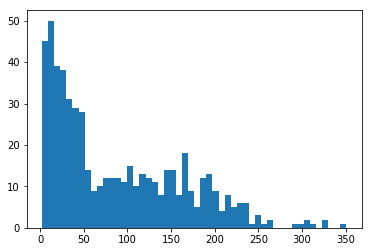

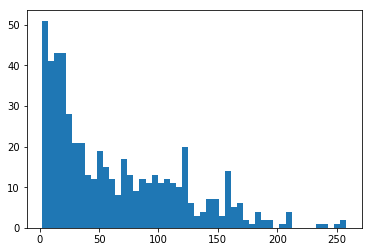

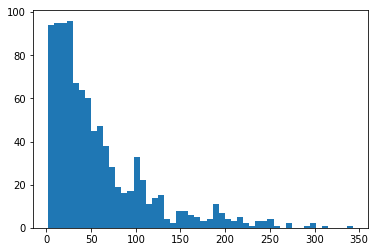

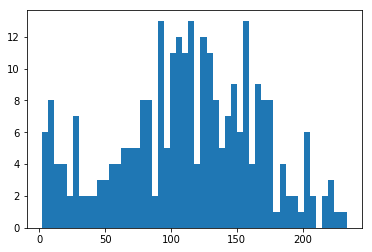

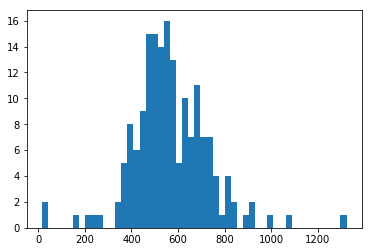

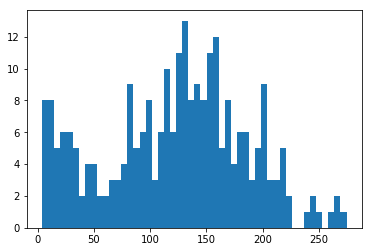

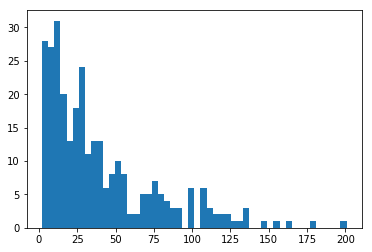

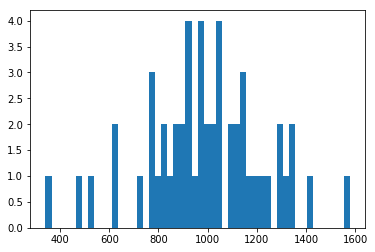

In [27]:
for u in all_units:
    u_idx = deconvd_sp[:, 1] == u
    plt.hist(dist_metric[u_idx], 50)
    plt.show()